In [1]:
from pathlib import Path
import tqdm
from multiprocessing import Pool
from functools import partial
import pickle

import warnings
warnings.simplefilter('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# import db_queries

from spatial_temp_cgf.data_prep.location_mapping import FHS_HIERARCHY_PATH

ROOT = Path('/mnt/team/rapidresponse/pub/population/modeling/climate_malnutrition')


In [2]:
fhs_loc_meta = pd.read_parquet(FHS_HIERARCHY_PATH).sort_values('sort_order').reset_index(drop=True)

# location_ids = fhs_loc_meta.loc[fhs_loc_meta['most_detailed'] == 1, 'location_id'].to_list()
versions = {
    'stunting': {
        'base model': {
            'model': '2024_07_09.01',
            'results': '2024_07_09.01',
        },
        'base model + temp': {
            'model': '2024_07_09.02',
            'results': '2024_07_09.02',
        },
        'base model + elevation': {
            'model': '2024_07_09.03',
            'results': '2024_07_09.03',
        },
        'base model + temp + elevation': {
            'model': '2024_07_09.04',
            'results': '2024_07_09.04',
        },
    },
    'wasting': {
        'base model': {
            'model': '2024_07_09.01',
            'results': '2024_07_10.01',
        },
        'base model + temp': {
            'model': '2024_07_09.02',
            'results': '2024_07_10.02',
        },
        'base model + elevation': {
            'model': '2024_07_09.03',
            'results': '2024_07_10.03',
        },
        'base model + temp + elevation': {
            'model': '2024_07_09.04',
            'results': '2024_07_10.04',
        },
    },
}
scenarios = ['ssp119']
year_ids = list(range(2020, 2023))  # list(range(2020, 2101))
age_group_ids = [4, 5]
sex_ids = [1, 2]


In [17]:
# def load_prediction(location_id: int, root: Path, label: str, measure: str, scenario: str, year_id: int):
#     try:
#         data = pd.read_parquet(root / 'results' / label / f'{measure}_{location_id}_{scenario}_{year_id}.parquet').reset_index()
#         data['location_id'] = data['fhs_location_id'].astype(int)
#         return data.set_index(['location_id', 'year_id', 'age_group_id', 'sex_id', 'scenario', 'measure']).loc[:, 'affected_proportion']
#     except FileNotFoundError:
#         return pd.Series()

def load_model(root: Path, measure: str, version: str, age_group_id: int, sex_id: int):
    with open(root / measure / 'models'/ version / f'{age_group_id}_{sex_id}.pkl', 'rb') as file:
        model = pickle.load(file)
    return model


def load_random_effects(root: Path, measure: str, version: str,
                        version_label: str, age_group_id: int, sex_id: int, fhs_loc_meta: pd.DataFrame):
    data = load_model(root, measure, version, age_group_id, sex_id).ranef
    data['version_label'] = version_label
    data['age_group_id'] = age_group_id
    data['sex_id'] = sex_id
    data['measure'] = measure
    fhs_loc_meta['ihme_loc_id'] = fhs_loc_meta['ihme_loc_id'].str[:3]
    data = data.join(fhs_loc_meta.set_index('ihme_loc_id').loc[:, 'location_id'])

    return data.set_index(['version_label', 'measure', 'location_id', 'age_group_id', 'sex_id']).loc[:, 'X.Intercept.']


def load_prediction(year_id: int, root: Path, measure: str, version: str, version_label: str, scenario: str):
    data = pd.read_parquet(root / measure / 'results' / version / f'{year_id}_{scenario}.parquet')
    data['year_id'] = year_id
    data['version_label'] = version_label
    data['measure'] = measure

    return data.set_index(['version_label', 'measure', 'location_id', 'year_id', 'age_group_id', 'sex_id']).loc[:, 'value'].sort_index()


random_effects = []
predictions = []
for measure, measure_versions in versions.items():
    for version_label, version_dict in measure_versions.items():
        for age_group_id in age_group_ids:
            for sex_id in sex_ids:
                random_effects.append(
                    load_random_effects(ROOT, measure, version_dict['model'],
                                        version_label, age_group_id, sex_id, fhs_loc_meta)
                )
        for year_id in year_ids:
            for scenario in scenarios:
                # load_predictions = partial(
                #     load_prediction,
                #     root=ROOT,
                #     label=LABEL,
                #     measure=measure,
                #     scenario=scenario,
                #     year_id=year_id,
                # )
                # with Pool(20) as pool:
                #     location_predictions = list(pool.imap(load_predictions, location_ids))
                predictions.append(load_prediction(year_id, ROOT, measure, version_dict['results'], version_label, scenario))
predictions = pd.concat(predictions).sort_index().rename('pred')
random_effects = pd.concat(random_effects).sort_index().rename('ranef')


In [73]:
predictions

version_label                  measure   location_id  year_id  age_group_id  sex_id
base model                     stunting  7            2020     4             1         0.215726
                                                                             2         0.163127
                                                               5             1         0.413511
                                                                             2         0.371577
                                                      2021     4             1         0.215970
                                                                                         ...   
base model + temp + elevation  wasting   60137        2021     5             2         0.000000
                                                      2022     4             1         1.000000
                                                                             2         1.000000
                                                    

In [19]:
random_effects

version_label                  measure   location_id  age_group_id  sex_id
base model                     stunting  10           4             1         0.120203
                                                                    2         0.113037
                                                      5             1         0.379460
                                                                    2         0.465450
                                         15           4             1        -0.552873
                                                                                ...   
base model + temp + elevation  wasting   53620        5             2         0.330441
                                         53621        4             1         0.616899
                                                                    2         0.553254
                                                      5             1         0.283617
                                                       

In [20]:
# kwargs = {}
# for id_var in ['location_id', 'year_id', 'age_group_id', 'sex_id']:
#     kwargs[id_var] = predictions.index.get_level_values(id_var).unique().tolist()
# gbd = db_queries.get_outputs(
#     'rei',
#     release_id=9,
#     measure_id=29,
#     metric_id=3,
#     rei_id=[240, 241],
#     **kwargs
# )
# gbd['measure'] = gbd['rei'].str.replace('nutrition_', '')
# gbd = gbd.set_index(['location_id', 'year_id', 'age_group_id', 'sex_id', 'measure']).sort_index().loc[:, 'val'].rename('gbd')

# plot_data = predictions.loc[:, :, :, :, 'ssp119', :].to_frame().join(gbd).dropna()

# plt.scatter(
#     plot_data['gbd'],
#     plot_data['pred'],
#     alpha=0.25
# )
# plt.plot((0, 1), (0, 1), color='red')

In [21]:
# me_ids = db_queries.get_ids('modelable_entity')
# me_ids.loc[me_ids['modelable_entity_id'].isin([8949, 8950, 8951, 10556, 10557,
#                                                8945, 8946, 8947, 10558, 10559])]


In [22]:
# me_ids = db_queries.get_ids('modelable_entity')
# me_ids.loc[
#     (me_ids['modelable_entity_name'].str.contains('asting'))
#     & (me_ids['modelable_entity_name'].str.contains('oderate'))
# ]
# me_ids.loc[
#     (me_ids['modelable_entity_name'].str.contains('tunting'))
#     & (me_ids['modelable_entity_name'].str.contains('oderate'))
# ]

# 10557 --> Mild Stunting, < -1 SD (post-ensemble)
# 10559 --> Mild Wasting, < -1 SD (post-ensemble)

# 10556 --> Moderate Stunting, < -2 SD (post-ensemble)
# 10558 --> Moderate Wasting, < -2 SD (post-ensemble)


In [23]:
# age_metadata = db_queries.get_age_metadata(release_id=9)
age_metadata = pd.read_parquet(ROOT / 'input' / 'gbd_prevalence' / 'age_metadata.parquet')
age_metadata = age_metadata.loc[age_metadata['age_group_days_start'] >= 28]
age_metadata = age_metadata.loc[age_metadata['age_group_years_end'] <= 5]

kwargs = {}
for id_var in ['location_id', 'year_id', 'sex_id']:  # , 'age_group_id'
    kwargs[id_var] = predictions.index.get_level_values(id_var).unique().tolist()

population = pd.read_parquet(ROOT / 'input' / 'gbd_prevalence' / 'population.parquet')

gbd = []
for measure, me_id in [('stunting', 10556), ('wasting', 10558)]:  # Moderate
# for measure, me_id in [('stunting', 10557), ('wasting', 10559)]:  # Mild
# for measure, me_id in [('stunting', 8949), ('stunting', 8950), ('stunting', 8951),
#                        ('wasting', 8945), ('wasting', 8946), ('wasting', 8947)]:  # Combine individual models
    # _gbd = db_queries.get_model_results(
    #     'epi',
    #     me_id,
    #     release_id=9,
    #     measure_id=5,
    #     age_group_id=age_metadata['age_group_id'].to_list(),
    #     **kwargs
    # )
    _gbd = pd.read_parquet(ROOT / 'input' / 'gbd_prevalence' / f'{measure}.parquet')
    _gbd['measure'] = measure
    gbd.append(_gbd)
gbd = pd.concat(gbd)
gbd = gbd.groupby(['measure', 'location_id', 'year_id', 'age_group_id', 'sex_id'], as_index=False)['mean'].sum()

gbd = gbd.merge(population)
gbd = gbd.merge(age_metadata.loc[:, ['age_group_id', 'age_group_years_start', 'age_group_years_end']])
gbd.loc[gbd['age_group_years_end'] <= 1, 'age_group_id'] = 4
gbd.loc[gbd['age_group_years_start'] >= 1, 'age_group_id'] = 5
gbd['gbd'] = gbd['mean'] * gbd['population']
gbd = gbd.groupby(['measure', 'location_id', 'year_id', 'age_group_id', 'sex_id'])['gbd', 'population'].sum()
gbd['gbd'] /= gbd['population']


In [24]:
# inputs = pd.read_parquet('/mnt/team/rapidresponse/pub/population/modeling/climate_malnutrition/stunting/training_data/2024_06_30.02/data.parquet')
# inputs['scenario'] = 'ssp119'
# inputs['year_id'] = inputs['int_year']
# for int_var in ['location_id', 'year_id', 'age_group_id', 'sex_id']:
#     inputs[int_var] = inputs[int_var].astype(int)
# inputs = inputs.groupby(['location_id', 'year_id', 'age_group_id', 'sex_id', 'scenario'])[['stunting', 'wasting']].mean()
# inputs.columns.name = 'measure'
# inputs = inputs.stack().rename('pred')


In [124]:
plot_data = predictions.to_frame().join(gbd).dropna().join(random_effects, how='left').reorder_levels(predictions.index.names)
plot_data['has_raneff'] = plot_data['ranef'].notnull()
plot_data = plot_data.loc[:, :, :, :, [4], [1]]
## plot_data = inputs.loc[:, :, :, :, 'ssp119', :].to_frame().join(gbd).dropna()
plot_data['pred'] *= plot_data['population']
plot_data['gbd'] *= plot_data['population']
plot_data = plot_data.groupby(['version_label', 'measure', 'has_raneff', 'location_id', 'year_id'])['pred', 'gbd', 'population'].sum()
plot_data['pred'] /= plot_data['population']
plot_data['gbd'] /= plot_data['population']
plot_data = plot_data.drop('population', axis=1)
plot_data.describe()
# plot_data = np.log(plot_data + plot_data['gbd'].min() / 10)


,pred,gbd
count,11304.000000,11304.000000
mean,0.245841,0.097379
std,0.247698,0.076341
min,0.000000,0.003139
25%,0.077495,0.032922
50%,0.128612,0.074607
75%,0.428105,0.145031
max,1.000000,0.428638


In [127]:
plot_data.loc[:, 'wasting', True, :, :]

pred       gbd
version_label                 location_id year_id                    
base model                    10          2020     0.611968  0.107595
                                          2021     0.611674  0.107080
                                          2022     0.611373  0.106824
                              15          2020     0.386631  0.063841
                                          2021     0.386531  0.063552
...                                                     ...       ...
base model + temp + elevation 53620       2021     0.701538  0.179986
                                          2022     0.701411  0.178453
                              53621       2020     0.707462  0.232356
                                          2021     0.707320  0.228397
                                          2022     0.707147  0.225999

[1632 rows x 2 columns]

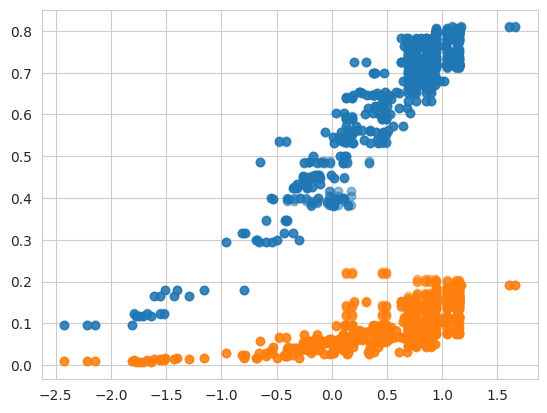

In [89]:
foo = plot_data.loc[['base model'], ['wasting'], True, :, :].join(random_effects)
foo['resid'] = foo['pred'] - foo['gbd']
plt.scatter(foo['ranef'], foo['pred'], alpha=0.5)
plt.scatter(foo['ranef'], foo['gbd'], alpha=0.5)


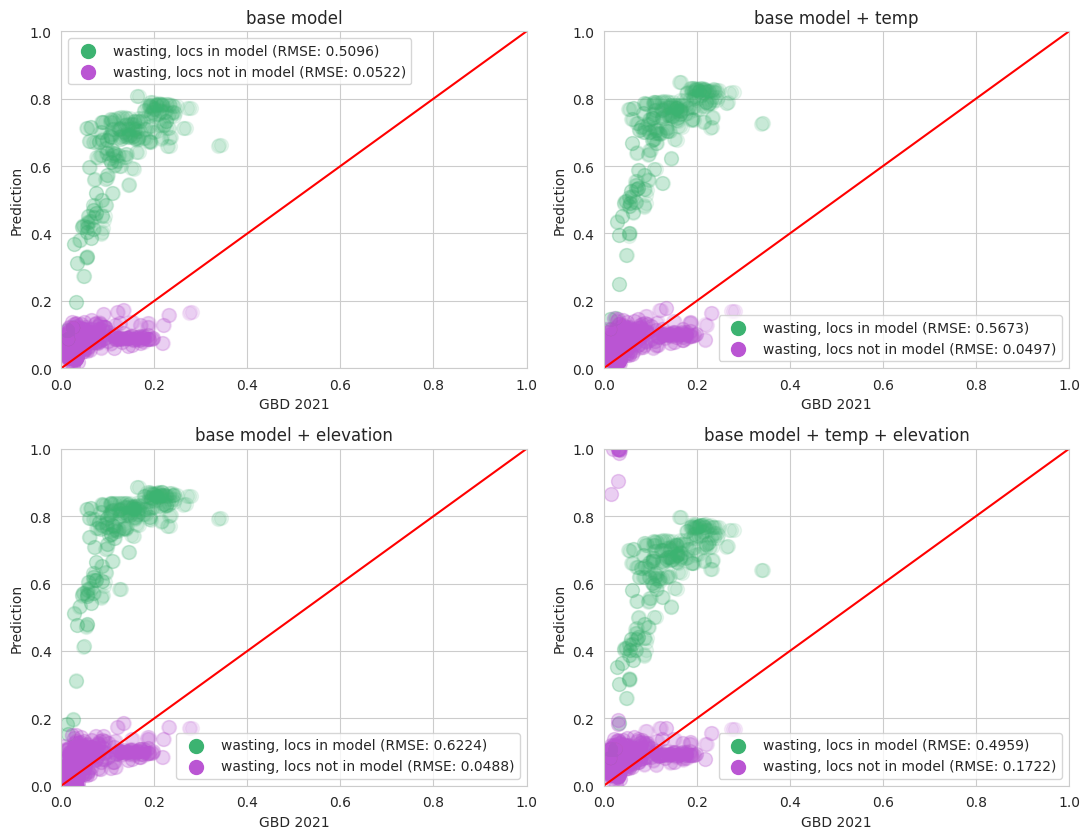

In [70]:
sns.set_style('whitegrid')

for measure, measure_versions in versions.items():
    # if measure == 'stunting':
    marker = 'o'
    fig, ax = plt.subplots(2, 2, figsize=(11, 8.5))
    for i, (version_label, version_dict) in enumerate(measure_versions.items()):
        idx = int(i >= 2), i % 2
        label = f"{version_label}"
        sublabel = f""
        # version = version_dict['results']
        # for measure, marker in [('stunting', 'o')]:  # , ('wasting', 's')
        for re, color in [(True, 'mediumseagreen'), (False, 'mediumorchid')]:
            rmse = np.round(
                (
                    (
                        plot_data.loc[version_label, measure, re, :, :].loc[:, 'gbd'] - plot_data.loc[version_label, measure, re, :, :].loc[:, 'pred']
                    ) ** 2
                ).mean() ** 0.5,
                4
            )
            if re:
                legend_label = f'{measure}, locs in model (RMSE: {rmse})'
            else:
                legend_label = f'{measure}, locs not in model (RMSE: {rmse})'
            ax[idx].scatter(
                plot_data.loc[version_label, measure, re, :, :].loc[:, 'gbd'],
                plot_data.loc[version_label, measure, re, :, :].loc[:, 'pred'],
                color=color,
                s=100,
                alpha=0.1,
                marker=marker,
            )
            ax[idx].scatter(
                np.nan,
                np.nan,
                color=color,
                label=legend_label,
                s=100,
                alpha=1.,
                marker=marker,
            )
        ax[idx].plot((0, 1), (0, 1), color='red')
        ax[idx].set_ylabel('Prediction')
        ax[idx].set_xlabel('GBD 2021')
        ax[idx].set_ylim(0, 1)
        ax[idx].set_xlim(0, 1)
        ax[idx].set_title(label)
        ax[idx].legend()
    fig.tight_layout()
    fig.show()


In [ ]:
# stunting_grid = stunting_data.groupby('grid_cell').stunting.mean()
# wasting_grid = wasting_data.groupby('grid_cell').stunting.mean()
model.formula

In [ ]:
pd.concat([stunting_grid, wasting_grid.rename('wasting')], axis=1).dropna()

In [ ]:

import pickle

def load_model_data(root: Path, label: str, measure: str, age_group_id: int, sex_id: int):
    with open(root / 'models' / label / f'model_{measure}_{age_group_id}_{sex_id}.pkl', 'rb') as file:
        model = pickle.load(file)
    data = model.data
    data['age_group_id'] = age_group_id
    data['sex_id'] = sex_id
    data['measure'] = measure
    data = data.rename(columns={measure: 'obs'})
    return data.groupby(['ihme_loc_id', 'age_group_id', 'sex_id', 'measure'])[['obs', 'fits']].mean()


In [ ]:
new = pd.read_parquet('/mnt/team/rapidresponse/pub/population/modeling/climate_malnutrition/stunting/training_data/2024_06_30.02/data.parquet')
for int_var in ['age_group_id', 'sex_id']:
    new[int_var] = new[int_var].astype(int)
new = new.groupby(['ihme_loc_id', 'age_group_id', 'sex_id'])[['stunting', 'wasting']].mean()
new.columns.name = 'measure'
new = new.stack().rename('pred')

old = []
for age_group_id in [4, 5]:
    for sex_id in [1, 2]:
        old.append(load_model_data(ROOT, LABEL, 'stunting', age_group_id, sex_id))
old = pd.concat(old).sort_index()
old

In [ ]:
old.loc['ZWE']

In [ ]:
foo = pd.concat([
    new.rename('new'),
    old.rename('old')
], axis=1).loc[:, :, :, 'stunting']
plt.scatter(
    foo['new'],
    foo['old'],
)
plt.xlabel('From dataset')
plt.ylabel('From model object')
plt.show()

In [ ]:
foo.loc['ZWE']

In [ ]:
predictions.loc[198, :, :, :, 'ssp119', 'stunting'].groupby(['age_group_id', 'sex_id']).mean()

In [ ]:
root=ROOT
label=LABEL
measure='stunting'
age_group_id=5
sex_id=1
with open(root / 'models' / label / f'model_{measure}_{age_group_id}_{sex_id}.pkl', 'rb') as file:
    model = pickle.load(file)
md = model.data
md = md.loc[md['ihme_loc_id'] == 'ZWE']
md = md.groupby('grid_cell')[['stunting', 'fits']].mean()
plt.scatter(md['stunting'], md['fits'])
plt.xlabel('obs')
plt.ylabel('pred')
plt.plot((0, 1), (0, 1), color='red')
plt.show()


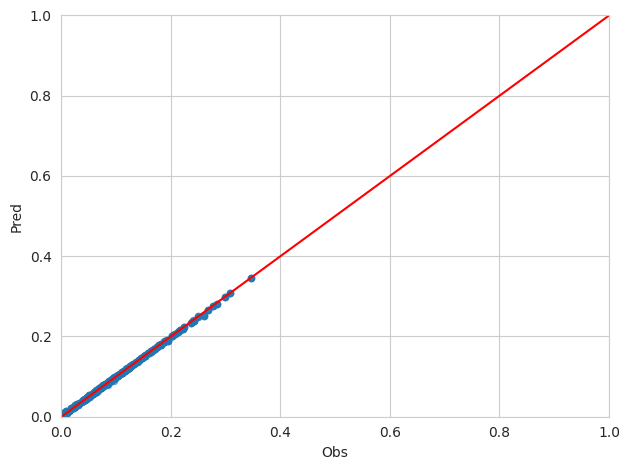

In [91]:
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

measure = 'wasting'
VERSIONS = ['2024_07_09.01', '2024_07_09.02', '2024_07_09.03', '2024_07_09.04']

input_data = []
models = {}
for version in VERSIONS:
    for age_group_id in [4, 5]:
        for sex_id in [1, 2]:
            with open(f'/mnt/team/rapidresponse/pub/population/modeling/climate_malnutrition/{measure}/models/{version}/{age_group_id}_{sex_id}.pkl', 'rb') as file:
                model = pickle.load(file)
            data = model.data
            data['version'] = version
            data['measure'] = measure
            data['age_group_id'] = age_group_id
            data['sex_id'] = sex_id
            data = data.rename(columns={measure: 'obs'})
            input_data.append(data)
            models[f'{version}_{age_group_id}_{sex_id}'] = model
input_data = pd.concat(input_data)
plot_inputs = input_data.groupby(['version', 'ihme_loc_id', 'age_group_id', 'sex_id', 'measure'])[['obs', 'fits']].mean()

plt.scatter(
    plot_inputs['obs'],
    plot_inputs['fits'],
    s=20,
    alpha=0.5
)
plt.plot(
    (0, 1),
    (0, 1),
    color='red'
)
plt.xlim(0, 1)
plt.xlabel('Obs')
plt.ylim(0, 1)
plt.ylabel('Pred')
plt.tight_layout()
plt.show()


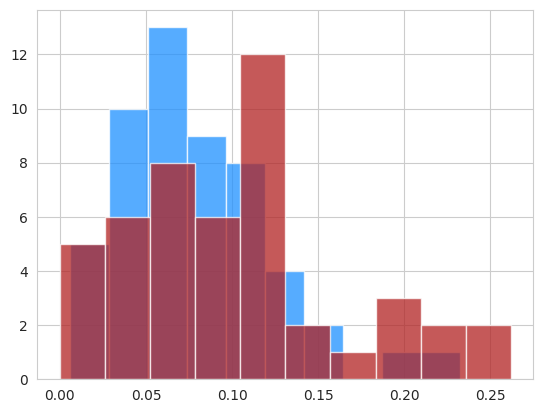

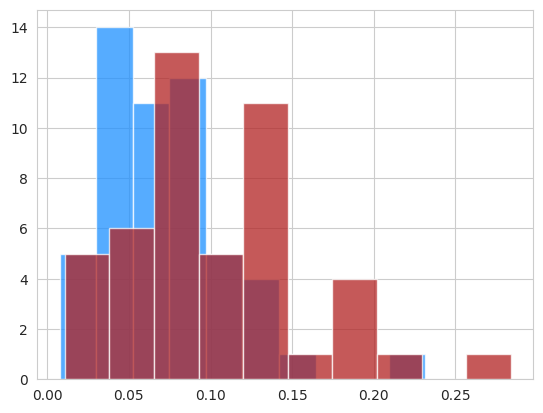

In [54]:
data = input_data.loc[input_data['version'] == '2024_07_09.01']
data['lin_residuals'] = 1 / (1 + np.exp(-data['residuals']))
data = data.groupby(['any_days_over_30C', 'ihme_loc_id'])['obs', 'fits', 'lin_residuals'].mean()
data.loc[0, 'obs'].hist(color='dodgerblue', alpha=0.75, label='0 days over 30')
data.loc[1, 'obs'].hist(color='firebrick', alpha=0.75, label='1+ days over 30')
plt.show()
data.loc[0, 'fits'].hist(color='dodgerblue', alpha=0.75, label='0 days over 30')
data.loc[1, 'fits'].hist(color='firebrick', alpha=0.75, label='1+ days over 30')
plt.show()

In [109]:
1 / (
    1 + np.exp(
        -(
            -2.065182 * 1 # intercept
            + 0.256654 * 1 # days over 30
            + -0.441034 * 0 # income
            + 0.242929 * 1 # any days over 30
            + 0.359003 * 0 # income/any days over 30
        )
    )
)

0.17284469443892012

In [121]:
foo = 0
for i in range(10):
    foo += 0.1 * 1 / (
        1 + np.exp(
            -(
                # -2.065182 * 1 # intercept
                + 0.256654 * 0 # days over 30
                + -0.441034 * 5 # income
                + 0.242929 * 0 # any days over 30
                + 0.359003 * 0 # income/any days over 30
            )
        )
    )
foo

0.09928718116901945

In [55]:
print(measure)
coefs = []
for label, model in models.items():
    coefs.append(models[label].coefs['Estimate'].rename(label))
pd.concat(coefs, axis=1)

wasting


,2024_07_09.01_4_1,2024_07_09.01_4_2,2024_07_09.01_5_1,2024_07_09.01_5_2,2024_07_09.02_4_1,2024_07_09.02_4_2,2024_07_09.02_5_1,2024_07_09.02_5_2,2024_07_09.03_4_1,2024_07_09.03_4_2,2024_07_09.03_5_1,2024_07_09.03_5_2,2024_07_09.04_4_1,2024_07_09.04_4_2,2024_07_09.04_5_1,2024_07_09.04_5_2
(Intercept),-2.065182,-2.304659,-2.710490,-2.938894,-2.359216,-2.655181,-2.888324,-3.159531,-1.998680,-2.198767,-2.765773,-2.951255,-2.674548,-2.791658,-3.858586,-3.907941
days_over_30C,0.256654,0.271687,0.351680,0.239554,0.162140,0.161355,0.295114,0.169036,0.250959,0.262521,0.355827,0.240460,0.106082,0.137645,0.129509,0.039734
ldi_pc_pd,-0.441034,-0.284587,-0.537008,-0.341962,-0.459130,-0.308999,-0.553057,-0.363793,-0.462334,-0.316589,-0.519008,-0.337921,-0.436265,-0.300769,-0.491263,-0.320731
any_days_over_30C,0.242929,0.278799,0.185731,0.282420,0.167233,0.188637,0.130524,0.214787,0.211525,0.229171,0.215629,0.289045,0.167011,0.188204,0.136010,0.218442
ldi_pc_pd:any_days_over_30C,0.359003,0.145883,0.260084,0.072306,0.375133,0.165935,0.274598,0.091504,0.376791,0.171951,0.244893,0.068868,0.356672,0.159243,0.224958,0.055790
mean_temperature,NaN,NaN,NaN,NaN,0.512741,0.611772,0.318236,0.394832,NaN,NaN,NaN,NaN,0.867806,0.765977,1.402423,1.233470
elevation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.198534,-0.317484,0.155629,0.035047,0.335137,0.144857,1.037161,0.801535


In [57]:
print(measure)
coefs = []
for label, model in models.items():
    coefs.append(models[label].coefs['Estimate'].rename(label))
pd.concat(coefs, axis=1)

stunting


,2024_07_09.01_4_1,2024_07_09.01_4_2,2024_07_09.01_5_1,2024_07_09.01_5_2,2024_07_09.02_4_1,2024_07_09.02_4_2,2024_07_09.02_5_1,2024_07_09.02_5_2,2024_07_09.03_4_1,2024_07_09.03_4_2,2024_07_09.03_5_1,2024_07_09.03_5_2,2024_07_09.04_4_1,2024_07_09.04_4_2,2024_07_09.04_5_1,2024_07_09.04_5_2
(Intercept),-1.208812,-1.556616,-0.121990,-0.283383,-0.849701,-1.241532,0.259390,0.112838,-1.421735,-1.762844,-0.329712,-0.489324,-1.739181,-2.234784,-0.500338,-0.539626
days_over_30C,0.131266,0.235988,0.290846,0.307511,0.254837,0.343774,0.417924,0.440670,0.146337,0.250677,0.304817,0.322147,0.073280,0.143113,0.266887,0.310958
ldi_pc_pd,-0.809945,-0.779101,-2.269417,-2.452338,-0.783447,-0.748453,-2.227223,-2.402686,-0.720010,-0.686864,-2.160356,-2.334541,-0.701290,-0.664040,-2.149268,-2.331073
any_days_over_30C,-0.025235,0.008612,-0.078951,-0.066920,0.070918,0.093313,0.030373,0.047735,0.077161,0.107831,0.026050,0.037240,0.057220,0.077859,0.014583,0.033850
ldi_pc_pd:any_days_over_30C,0.354135,0.159570,0.847750,0.924278,0.335645,0.139117,0.825635,0.900321,0.281298,0.086932,0.765418,0.835895,0.264390,0.065085,0.753780,0.832047
mean_temperature,NaN,NaN,NaN,NaN,-0.636679,-0.560374,-0.684309,-0.713562,NaN,NaN,NaN,NaN,0.408056,0.608496,0.221299,0.065272
elevation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.601735,0.576341,0.580875,0.569974,0.846394,0.937061,0.712972,0.608807


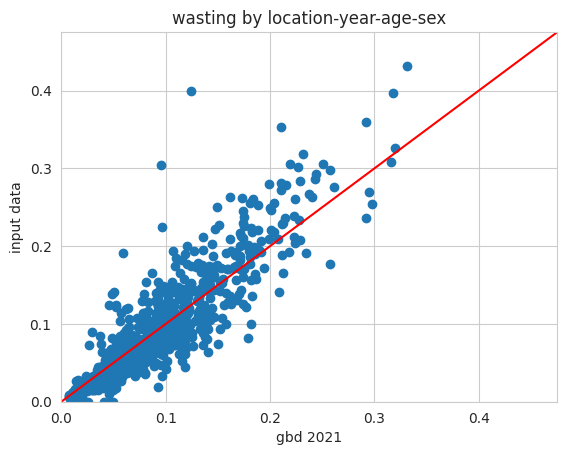

In [108]:
# dir(models['2024_07_09.01_4_1'])
measure = 'wasting'
data = pd.read_parquet(f'/mnt/team/rapidresponse/pub/population/modeling/climate_malnutrition/{measure}/training_data/2024_07_09.01/data.parquet')
data['year_id'] = data['int_year']
id_vars = ['location_id', 'year_id', 'age_group_id', 'sex_id']
for id_var in id_vars:
    data[id_var] = data[id_var].astype(int)
data = data.groupby(id_vars)['wasting'].mean().rename('dhs')
data = gbd.loc[measure].join(data, how='right')
plt.scatter(data['gbd'], data['dhs'])
plot_max = min(1, data[['gbd', 'dhs']].max().max() * 1.1)
plt.plot((0, plot_max), (0, plot_max), color='red')
plt.xlim(0, plot_max)
plt.ylim(0, plot_max)
plt.title(f'{measure} by location-year-age-sex')
plt.xlabel('gbd 2021')
plt.ylabel('input data')
plt.show()
# data.columns

In [ ]:
models['5_2'].var_info['ldi_pc_pd']['transformer']

In [ ]:
models['5_2'].data.describe()

In [ ]:
pd.read_parquet('/mnt/team/rapidresponse/pub/population/modeling/climate_malnutrition/stunting/results/2024_07_02.01/2020_ssp119.parquet').describe()

In [ ]:
from pathlib import Path

import click
import numpy as np
import pandas as pd
import rasterra as rt
from rasterio.features import rasterize
from rra_tools import jobmon
import geopandas as gpd

from spatial_temp_cgf import utils
from spatial_temp_cgf import cli_options as clio
from spatial_temp_cgf.data import ClimateMalnutritionData, DEFAULT_ROOT
from spatial_temp_cgf.model_specification import PredictorSpecification, ModelSpecification


def get_intercept_raster(
    pred_spec: PredictorSpecification,
    coefs: pd.DataFrame,
    ranefs: pd.DataFrame,
    fhs_shapes: gpd.GeoDataFrame,
    raster_template: rt.RasterArray,
) -> rt.RasterArray:
    icept = coefs.loc['(Intercept)']
    if pred_spec.random_effect == 'ihme_loc_id':
        shapes = list(
            ranefs['X.Intercept.'].reset_index()
            .merge(fhs_shapes, left_on='index', right_on='ihme_lc_id', how='left')
            .loc[:, ['geometry', 'X.Intercept.']]
            .itertuples(index=False, name=None)
        )
        icept_arr = rasterize(
            shapes,
            out=icept*np.ones_like(raster_template),
            transform=raster_template.transform,
        )
        icept_raster = rt.RasterArray(
            icept_arr,
            transform=raster_template.transform,
            crs=raster_template.crs,
            no_data_value=np.nan
        )
    elif not pred_spec.random_effect:
        icept_raster = raster_template + icept
    else:
        msg = 'Only location random intercepts are supported'
        raise NotImplementedError(msg)
    return icept_raster


def get_model_prevalence(
    model,
    spec: ModelSpecification,
    cmip6_scenario: str,
    year: int,
    cm_data: ClimateMalnutritionData,
    fhs_shapes: gpd.GeoDataFrame,
    raster_template: rt.RasterArray,
) -> rt.RasterArray:
    coefs = model.coefs['Estimate']
    ranefs = model.ranef
    
    partial_estimates = {}
    shape_map = fhs_shapes[fhs_shapes.most_detailed == 1].set_index('loc_id').geometry.to_dict()
    df = []
    for predictor in spec.predictors[1:]:
        print(predictor.name)
        if predictor.name == 'ldi_pc_pd':
            # continue  # deal with after
            v = sum([cm_data.load_ldi(year, f"{i / 10.:.1f}") for i in range(1, 11)])
        elif predictor.name == 'intercept':
            partial_estimates[predictor.name] = get_intercept_raster(
                predictor, coefs, ranefs, fhs_shapes, raster_template,
            )
        else:
            if predictor.random_effect:
                msg = 'Random slopes not implemented'
                raise NotImplementedError(msg)
    
            if predictor.name == 'elevation':
                v = cm_data.load_elevation()
            else:
                transform = predictor.transform
                variable = (
                    transform.from_column
                    if hasattr(transform, 'from_column') else predictor.name
                )
                ds = cm_data.load_climate_raster(variable, cmip6_scenario, year)
                v = utils.xarray_to_raster(ds, nodata=np.nan).resample_to(raster_template)
        vals = rt.RasterArray(
                        np.array(model.var_info[predictor.name]['transformer'](v)),
                        transform=v.transform,
                        crs=v.crs,
                        no_data_value=np.nan,
            )
        count = vals * fhs_pop_raster
        out = []
        for shape_id, shape in tqdm.tqdm(shape_map.items(), total=len(shape_map)):
            numerator = np.nansum(count.clip(shape).mask(shape))
            denominator = np.nansum(fhs_pop_raster.clip(shape).mask(shape))
            out.append((
                shape_id,
                year,
                model_dict['age_group_id'],
                model_dict['sex_id'],
                numerator / denominator,
            ))
        df.append(
            pd.DataFrame(out, columns=['location_id', 'year_id', 'age_group_id', 'sex_id', predictor.name])
            .set_index(['location_id', 'year_id', 'age_group_id', 'sex_id'])
            .loc[:, predictor.name]
        )
    df = pd.concat(df, axis=1)

            # beta = coefs.loc[predictor.name]
            # partial_estimates[predictor.name] = rt.RasterArray(
            #     beta * np.array(model.var_info[predictor.name]['transformer'](v)),
            #     transform=v.transform,
            #     crs=v.crs,
            #     no_data_value=np.nan,
            # )
    
    assert spec.extra_terms == ['any_days_over_30C * ldi_pc_pd']
    
    beta_interaction = (
        coefs.loc['ldi_pc_pd:any_days_over_30C'] / coefs.loc['any_days_over_30C']
    )
    beta_ldi = (
        beta_interaction * partial_estimates['any_days_over_30C']
        + coefs.loc['ldi_pc_pd']
    ).to_numpy()
    z_partial = sum(partial_estimates.values())
    
    prevalence = 0
    for i in range(1, 11):
        print(i)
        ldi = cm_data.load_ldi(year, f"{i / 10.:.1f}")
        
        z_ldi = rt.RasterArray(
            beta_ldi * np.array(model.var_info['ldi_pc_pd']['transformer'](ldi)),
            transform=ldi.transform,
            crs=ldi.crs,
            no_data_value=np.nan,
        )
        prevalence += 0.1 * 1 / (1 + np.exp(-(z_partial + z_ldi)))
    
    return prevalence.astype(np.float32)

def model_inference_main(
    output_dir: Path,    
    measure: str,
    results_version: str,
    model_version: str,
    cmip6_scenario: str,
    year: int,
) -> None:
    cm_data = ClimateMalnutritionData(output_dir / measure)
    spec = cm_data.load_model_specification(model_version)
    print('loading raster template and shapes')
    raster_template = cm_data.load_raster_template()
    fhs_shapes = cm_data.load_fhs_shapes(most_detailed_only=False)        
    print("loading population")
    fhs_pop_raster = cm_data.load_population_raster().set_no_data_value(np.nan)
    print('loading models')
    models = cm_data.load_model_family(model_version)

    for i, model_dict in enumerate(models):
        print(f'Computing prevalence for model {i} of {len(models)}')
        model_prevalence = get_model_prevalence(
            model_dict['model'],
            spec,
            cmip6_scenario,
            year,
            cm_data,
            fhs_shapes,
            raster_template,
        )
        cm_data.save_raster_results(
            model_prevalence,
            results_version,
            cmip6_scenario,
            year,
            model_dict['age_group_id'],
            model_dict['sex_id'],
        )

        model_dict['prediction'] = model_prevalence

    print('Computing zonal statistics')
    shape_map = fhs_shapes[fhs_shapes.most_detailed == 1].set_index('loc_id').geometry.to_dict()
    out = []
    for model_dict in models:
        count = model_dict['prediction'] * fhs_pop_raster
        for shape_id, shape in shape_map.items():
            numerator = np.nansum(count.clip(shape).mask(shape))
            denominator = np.nansum(fhs_pop_raster.clip(shape).mask(shape))
            out.append((
                shape_id,
                model_dict['age_group_id'],
                model_dict['sex_id'],
                numerator / denominator,
            ))

    print('saving results table')
    df = pd.DataFrame(out, columns=['location_id', 'age_group_id', 'sex_id', 'value'])
    cm_data.save_results_table(df, results_version, cmip6_scenario, year)


@click.command()
@clio.with_output_root(DEFAULT_ROOT)
@clio.with_measure()
@clio.with_results_version()
@clio.with_model_version()
@clio.with_cmip6_scenario()
@clio.with_year()
def model_inference_task(
    output_root: str,
    measure: str,
    results_version: str,
    model_version: str,
    cmip6_scenario: str,
    year: str,
):
    """Run model inference."""
    model_inference_main(
        Path(output_root),
        measure,
        results_version,
        model_version,
        cmip6_scenario,
        int(year),
    )


@click.command()
@clio.with_output_root(DEFAULT_ROOT)
@clio.with_model_version()
@clio.with_measure()
@clio.with_cmip6_scenario(allow_all=True)
@clio.with_year(allow_all=True)
@clio.with_queue()
def model_inference(
    output_root: str,
    model_version: str,
    measure: str,
    cmip6_scenario: list[str],
    year: list[str],
    queue: str,
) -> None:
    """Run model inference."""
    cm_data = ClimateMalnutritionData(Path(output_root) / measure)
    results_version = cm_data.new_results_version()
    print(f"Running inference for {measure} using {model_version}. Results version: {results_version}")

    jobmon.run_parallel(
        runner="sttask",
        task_name="inference",
        node_args={
            "measure": [measure],
            "cmip6-scenario": cmip6_scenario,
            "year": year,
        },
        task_args={
            "output-root": output_root,
            "model-version": model_version,
            "results-version": results_version,
        },
        task_resources={
            "queue": queue,
            "cores": 1,
            "memory": "90Gb",
            "runtime": "240m",
            "project": "proj_rapidresponse",
        },
        max_attempts=1,
        log_root=str(cm_data.results / results_version),
    )

    print(f"Inference complete, results can be found at {cm_data.results / results_version}")


In [ ]:
from pathlib import Path

import click
import numpy as np
import pandas as pd
import rasterra as rt
from rasterio.features import rasterize
from rra_tools import jobmon
import geopandas as gpd

from spatial_temp_cgf import utils
from spatial_temp_cgf import cli_options as clio
from spatial_temp_cgf.data import ClimateMalnutritionData, DEFAULT_ROOT
from spatial_temp_cgf.model_specification import PredictorSpecification, ModelSpecification


def get_intercept_raster(
    pred_spec: PredictorSpecification,
    coefs: pd.DataFrame,
    ranefs: pd.DataFrame,
    fhs_shapes: gpd.GeoDataFrame,
    raster_template: rt.RasterArray,
) -> rt.RasterArray:
    icept = coefs.loc['(Intercept)']
    if pred_spec.random_effect == 'ihme_loc_id':
        shapes = list(
            ranefs['X.Intercept.'].reset_index()
            .merge(fhs_shapes, left_on='index', right_on='ihme_lc_id', how='left')
            .loc[:, ['geometry', 'X.Intercept.']]
            .itertuples(index=False, name=None)
        )
        icept_arr = rasterize(
            shapes,
            out=icept*np.ones_like(raster_template),
            transform=raster_template.transform,
        )
        icept_raster = rt.RasterArray(
            icept_arr,
            transform=raster_template.transform,
            crs=raster_template.crs,
            no_data_value=np.nan
        )
    elif not pred_spec.random_effect:
        icept_raster = raster_template + icept
    else:
        msg = 'Only location random intercepts are supported'
        raise NotImplementedError(msg)
    return icept_raster


def get_model_prevalence(
    model,
    spec: ModelSpecification,
    cmip6_scenario: str,
    year: int,
    cm_data: ClimateMalnutritionData,
    fhs_shapes: gpd.GeoDataFrame,
    raster_template: rt.RasterArray,
) -> rt.RasterArray:
    coefs = model.coefs['Estimate']
    ranefs = model.ranef
    
    partial_estimates = {}
    for predictor in spec.predictors:
        print(predictor.name)
        if predictor.name == 'ldi_pc_pd':
            continue  # deal with after
        elif predictor.name == 'intercept':
            partial_estimates[predictor.name] = get_intercept_raster(
                predictor, coefs, ranefs, fhs_shapes, raster_template,
            )
        else:
            if predictor.random_effect:
                msg = 'Random slopes not implemented'
                raise NotImplementedError(msg)
    
            if predictor.name == 'elevation':
                v = cm_data.load_elevation()
            else:
                transform = predictor.transform
                variable = (
                    transform.from_column
                    if hasattr(transform, 'from_column') else predictor.name
                )
                ds = cm_data.load_climate_raster(variable, cmip6_scenario, year)
                v = utils.xarray_to_raster(ds, nodata=np.nan).resample_to(raster_template)
    
            beta = coefs.loc[predictor.name]
            partial_estimates[predictor.name] = rt.RasterArray(
                beta * np.array(model.var_info[predictor.name]['transformer'](v)),
                transform=v.transform,
                crs=v.crs,
                no_data_value=np.nan,
            )
    
    assert spec.extra_terms == ['any_days_over_30C * ldi_pc_pd']
    
    beta_interaction = (
        coefs.loc['ldi_pc_pd:any_days_over_30C'] / coefs.loc['any_days_over_30C']
    )
    beta_ldi = (
        beta_interaction * partial_estimates['any_days_over_30C']
        + coefs.loc['ldi_pc_pd']
    ).to_numpy()
    z_partial = sum(partial_estimates.values())
    
    prevalence = {}
    for i in range(1, 11):
        print(i)
        ldi = cm_data.load_ldi(year, f"{i / 10.:.1f}")
        
        z_ldi = rt.RasterArray(
            beta_ldi * np.array(model.var_info['ldi_pc_pd']['transformer'](ldi)),
            transform=ldi.transform,
            crs=ldi.crs,
            no_data_value=np.nan,
        )
        prevalence[f"{i / 10.:.1f}"] = (1 / (1 + np.exp(-(z_partial + z_ldi)))).astype(np.float32)
    
    return prevalence

def model_inference_main(
    output_dir: Path,    
    measure: str,
    results_version: str,
    model_version: str,
    cmip6_scenario: str,
    year: int,
) -> None:
    cm_data = ClimateMalnutritionData(output_dir / measure)
    spec = cm_data.load_model_specification(model_version)
    print('loading raster template and shapes')
    raster_template = cm_data.load_raster_template()
    fhs_shapes = cm_data.load_fhs_shapes(most_detailed_only=False)        
    print("loading population")
    fhs_pop_raster = cm_data.load_population_raster().set_no_data_value(np.nan)
    print('loading models')
    models = cm_data.load_model_family(model_version)

    for i, model_dict in enumerate(models):
        print(f'Computing prevalence for model {i} of {len(models)}')
        model_prevalence = get_model_prevalence(
            model_dict['model'],
            spec,
            cmip6_scenario,
            year,
            cm_data,
            fhs_shapes,
            raster_template,
        )
        cm_data.save_raster_results(
            model_prevalence,
            results_version,
            cmip6_scenario,
            year,
            model_dict['age_group_id'],
            model_dict['sex_id'],
        )

        model_dict['prediction'] = model_prevalence

    print('Computing zonal statistics')
    shape_map = fhs_shapes[fhs_shapes.most_detailed == 1].set_index('loc_id').geometry.to_dict()
    df = []
    for income_decile, prediction in tqdm.tqdm(prevalence.items(), total=len(prevalence)):
        out = []
        count = prediction * fhs_pop_raster
        for shape_id, shape in shape_map.items():
            numerator = np.nansum(count.clip(shape).mask(shape))
            denominator = np.nansum(fhs_pop_raster.clip(shape).mask(shape))
            out.append((
                shape_id,
                year,
                model_dict['age_group_id'],
                model_dict['sex_id'],
                numerator / denominator,
            ))
        df.append(
            pd.DataFrame(out, columns=['location_id', 'year_id', 'age_group_id', 'sex_id', f'id {income_decile}'])
            .set_index(['location_id', 'year_id', 'age_group_id', 'sex_id'])
            .loc[:, f'id {income_decile}']
        )
    df = pd.concat(df, axis=1)

    print('saving results table')
    df = pd.DataFrame(out, columns=['location_id', 'year_id', 'age_group_id', 'sex_id', f'id {income_decile}'])
    cm_data.save_results_table(df, results_version, cmip6_scenario, year)


@click.command()
@clio.with_output_root(DEFAULT_ROOT)
@clio.with_measure()
@clio.with_results_version()
@clio.with_model_version()
@clio.with_cmip6_scenario()
@clio.with_year()
def model_inference_task(
    output_root: str,
    measure: str,
    results_version: str,
    model_version: str,
    cmip6_scenario: str,
    year: str,
):
    """Run model inference."""
    model_inference_main(
        Path(output_root),
        measure,
        results_version,
        model_version,
        cmip6_scenario,
        int(year),
    )


@click.command()
@clio.with_output_root(DEFAULT_ROOT)
@clio.with_model_version()
@clio.with_measure()
@clio.with_cmip6_scenario(allow_all=True)
@clio.with_year(allow_all=True)
@clio.with_queue()
def model_inference(
    output_root: str,
    model_version: str,
    measure: str,
    cmip6_scenario: list[str],
    year: list[str],
    queue: str,
) -> None:
    """Run model inference."""
    cm_data = ClimateMalnutritionData(Path(output_root) / measure)
    results_version = cm_data.new_results_version()
    print(f"Running inference for {measure} using {model_version}. Results version: {results_version}")

    jobmon.run_parallel(
        runner="sttask",
        task_name="inference",
        node_args={
            "measure": [measure],
            "cmip6-scenario": cmip6_scenario,
            "year": year,
        },
        task_args={
            "output-root": output_root,
            "model-version": model_version,
            "results-version": results_version,
        },
        task_resources={
            "queue": queue,
            "cores": 1,
            "memory": "90Gb",
            "runtime": "240m",
            "project": "proj_rapidresponse",
        },
        max_attempts=1,
        log_root=str(cm_data.results / results_version),
    )

    print(f"Inference complete, results can be found at {cm_data.results / results_version}")


In [ ]:
from pathlib import Path

import click
import numpy as np
import pandas as pd
import rasterra as rt
from rasterio.features import rasterize
from rra_tools import jobmon
import geopandas as gpd

from spatial_temp_cgf import utils
from spatial_temp_cgf import cli_options as clio
from spatial_temp_cgf.data import ClimateMalnutritionData, DEFAULT_ROOT
from spatial_temp_cgf.model_specification import PredictorSpecification, ModelSpecification


def get_intercept_raster(
    pred_spec: PredictorSpecification,
    coefs: pd.DataFrame,
    ranefs: pd.DataFrame,
    fhs_shapes: gpd.GeoDataFrame,
    raster_template: rt.RasterArray,
) -> rt.RasterArray:
    icept = coefs.loc['(Intercept)']
    if pred_spec.random_effect == 'ihme_loc_id':
        shapes = list(
            ranefs['X.Intercept.'].reset_index()
            .merge(fhs_shapes, left_on='index', right_on='ihme_lc_id', how='left')
            .loc[:, ['geometry', 'X.Intercept.']]
            .itertuples(index=False, name=None)
        )
        icept_arr = rasterize(
            shapes,
            out=icept*np.ones_like(raster_template),
            transform=raster_template.transform,
        )
        icept_raster = rt.RasterArray(
            icept_arr,
            transform=raster_template.transform,
            crs=raster_template.crs,
            no_data_value=np.nan
        )
    elif not pred_spec.random_effect:
        icept_raster = raster_template + icept
    else:
        msg = 'Only location random intercepts are supported'
        raise NotImplementedError(msg)
    return icept_raster


def get_model_prevalence(
    model,
    spec: ModelSpecification,
    cmip6_scenario: str,
    year: int,
    cm_data: ClimateMalnutritionData,
    fhs_shapes: gpd.GeoDataFrame,
    raster_template: rt.RasterArray,
) -> rt.RasterArray:
    coefs = model.coefs['Estimate']
    ranefs = model.ranef
    
    partial_estimates = {}
    shape_map = fhs_shapes[fhs_shapes.most_detailed == 1].set_index('loc_id').geometry.to_dict()
    covs = []
    preds = []
    for predictor in spec.predictors[1:]:
        print(predictor.name)
        if predictor.name == 'ldi_pc_pd':
            # continue  # deal with after
            vs = {f"_{i / 10.:.1f}": cm_data.load_ldi(year, f"{i / 10.:.1f}") for i in range(1, 11)}
        elif predictor.name == 'intercept':
            partial_estimates[predictor.name] = get_intercept_raster(
                predictor, coefs, ranefs, fhs_shapes, raster_template,
            )
        else:
            if predictor.random_effect:
                msg = 'Random slopes not implemented'
                raise NotImplementedError(msg)
    
            if predictor.name == 'elevation':
                v = cm_data.load_elevation()
            else:
                transform = predictor.transform
                variable = (
                    transform.from_column
                    if hasattr(transform, 'from_column') else predictor.name
                )
                ds = cm_data.load_climate_raster(variable, cmip6_scenario, year)
                vs = {'': utils.xarray_to_raster(ds, nodata=np.nan).resample_to(raster_template)}
        for v_suff, v in vs.items():
            vals = rt.RasterArray(
                np.array(model.var_info[predictor.name]['transformer'](v)),
                transform=v.transform,
                crs=v.crs,
                no_data_value=np.nan,
            )
            count = vals * fhs_pop_raster
            out = []
            for shape_id, shape in tqdm.tqdm(shape_map.items(), total=len(shape_map)):
                numerator = np.nansum(count.clip(shape).mask(shape))
                denominator = np.nansum(fhs_pop_raster.clip(shape).mask(shape))
                out.append((
                    shape_id,
                    year,
                    model_dict['age_group_id'],
                    model_dict['sex_id'],
                    numerator / denominator,
                ))
            covs.append(
                pd.DataFrame(out, columns=['location_id', 'year_id', 'age_group_id', 'sex_id', predictor.name])
                .set_index(['location_id', 'year_id', 'age_group_id', 'sex_id'])
                .loc[:, f'{predictor.name}{v_suff}']
            )
    covs_df = pd.concat(covs, axis=1)

            # beta = coefs.loc[predictor.name]
            # partial_estimates[predictor.name] = rt.RasterArray(
            #     beta * np.array(model.var_info[predictor.name]['transformer'](v)),
            #     transform=v.transform,
            #     crs=v.crs,
            #     no_data_value=np.nan,
            # )
    
    assert spec.extra_terms == ['any_days_over_30C * ldi_pc_pd']
    
    beta_interaction = (
        coefs.loc['ldi_pc_pd:any_days_over_30C'] / coefs.loc['any_days_over_30C']
    )
    beta_ldi = (
        beta_interaction * partial_estimates['any_days_over_30C']
        + coefs.loc['ldi_pc_pd']
    ).to_numpy()
    z_partial = sum(partial_estimates.values())
    
    prevalence = 0
    for i in range(1, 11):
        print(i)
        ldi = cm_data.load_ldi(year, f"{i / 10.:.1f}")
        
        z_ldi = rt.RasterArray(
            beta_ldi * np.array(model.var_info['ldi_pc_pd']['transformer'](ldi)),
            transform=ldi.transform,
            crs=ldi.crs,
            no_data_value=np.nan,
        )
        prevalence += 0.1 * 1 / (1 + np.exp(-(z_partial + z_ldi)))
    
    return prevalence.astype(np.float32)

def model_inference_main(
    output_dir: Path,    
    measure: str,
    results_version: str,
    model_version: str,
    cmip6_scenario: str,
    year: int,
) -> None:
    cm_data = ClimateMalnutritionData(output_dir / measure)
    spec = cm_data.load_model_specification(model_version)
    print('loading raster template and shapes')
    raster_template = cm_data.load_raster_template()
    fhs_shapes = cm_data.load_fhs_shapes(most_detailed_only=False)        
    print("loading population")
    fhs_pop_raster = cm_data.load_population_raster().set_no_data_value(np.nan)
    print('loading models')
    models = cm_data.load_model_family(model_version)

    for i, model_dict in enumerate(models):
        print(f'Computing prevalence for model {i} of {len(models)}')
        model_prevalence = get_model_prevalence(
            model_dict['model'],
            spec,
            cmip6_scenario,
            year,
            cm_data,
            fhs_shapes,
            raster_template,
        )
        cm_data.save_raster_results(
            model_prevalence,
            results_version,
            cmip6_scenario,
            year,
            model_dict['age_group_id'],
            model_dict['sex_id'],
        )

        model_dict['prediction'] = model_prevalence

    print('Computing zonal statistics')
    shape_map = fhs_shapes[fhs_shapes.most_detailed == 1].set_index('loc_id').geometry.to_dict()
    out = []
    for model_dict in models:
        count = model_dict['prediction'] * fhs_pop_raster
        for shape_id, shape in shape_map.items():
            numerator = np.nansum(count.clip(shape).mask(shape))
            denominator = np.nansum(fhs_pop_raster.clip(shape).mask(shape))
            out.append((
                shape_id,
                model_dict['age_group_id'],
                model_dict['sex_id'],
                numerator / denominator,
            ))

    print('saving results table')
    df = pd.DataFrame(out, columns=['location_id', 'age_group_id', 'sex_id', 'value'])
    cm_data.save_results_table(df, results_version, cmip6_scenario, year)


@click.command()
@clio.with_output_root(DEFAULT_ROOT)
@clio.with_measure()
@clio.with_results_version()
@clio.with_model_version()
@clio.with_cmip6_scenario()
@clio.with_year()
def model_inference_task(
    output_root: str,
    measure: str,
    results_version: str,
    model_version: str,
    cmip6_scenario: str,
    year: str,
):
    """Run model inference."""
    model_inference_main(
        Path(output_root),
        measure,
        results_version,
        model_version,
        cmip6_scenario,
        int(year),
    )


@click.command()
@clio.with_output_root(DEFAULT_ROOT)
@clio.with_model_version()
@clio.with_measure()
@clio.with_cmip6_scenario(allow_all=True)
@clio.with_year(allow_all=True)
@clio.with_queue()
def model_inference(
    output_root: str,
    model_version: str,
    measure: str,
    cmip6_scenario: list[str],
    year: list[str],
    queue: str,
) -> None:
    """Run model inference."""
    cm_data = ClimateMalnutritionData(Path(output_root) / measure)
    results_version = cm_data.new_results_version()
    print(f"Running inference for {measure} using {model_version}. Results version: {results_version}")

    jobmon.run_parallel(
        runner="sttask",
        task_name="inference",
        node_args={
            "measure": [measure],
            "cmip6-scenario": cmip6_scenario,
            "year": year,
        },
        task_args={
            "output-root": output_root,
            "model-version": model_version,
            "results-version": results_version,
        },
        task_resources={
            "queue": queue,
            "cores": 1,
            "memory": "90Gb",
            "runtime": "240m",
            "project": "proj_rapidresponse",
        },
        max_attempts=1,
        log_root=str(cm_data.results / results_version),
    )

    print(f"Inference complete, results can be found at {cm_data.results / results_version}")
